<a href="https://colab.research.google.com/github/Morax19/ML_UCV/blob/main/Tarea2/Tarea2_ML_DanielHernandez.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



TAREA 2: APRENDIZAJE SUPERVISADO<br>
Aprendizaje Automático, Escuela de Computación, Facultad de Ciencias - UCV
<br>
<br>
#Parte 1: Reconocimiento de Dígitos
<br>
<br>
Autor: Daniel Hernández<br>
Fecha: 14 de Febrero 2025



## Introducción

---

La función principal de este notebook es utilizar 3 modelos de Aprendizaje Automático con el objetivo de reconocer de dígitos manuscritos, cada modelo tendrá su sección con cada paso realizado, por último se compararán sus rendimientos.

En esta sección se muestran los pasos iniciales tales como la importación de librerías, descarga y pre-procesamiento de datos.


### Configuración del entorno

Lo primero que se define es el valor de la semilla a utilizar a lo largo del notebook, con la finalidad de poder reproducir los resultados.

In [1]:
#El valor de la semilla viene definido previamente
SEED = 27795163

Se importan las librerias necesarias:

In [2]:
import numpy as np
import joblib as jb
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import cross_validate, train_test_split, GridSearchCV

### Pre-procesamiento


El conjunto de datos con el que vamos a trabajar a lo largo de este notebook es [MNIST](https://docs.ultralytics.com/es/datasets/classify/mnist/). Las siglas de este conjunto de datos corresponden a "Modified National Institute of Standards and Technology" la cual es una base de datos que contiene 70 mil imágenes de dígitos desde el 0 hasta el 9, escritos a mano y debidamente identificados.

In [3]:
from keras.datasets import mnist

(X_train, y_train), (X_test, y_test) = mnist.load_data()

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Los datos se separan de la siguiente forma:


*   X: Contiene los valores de los píxeles correspondientes a las imágenes
*   y: Contiene las etiquetas asociadas cada una de ellas.



In [4]:
#Valores de los pixeles en un arreglo NumPy
X = np.concatenate((X_train, X_test), axis = 0)

#Etiquetas que identifican los objetivos de las imágenes
y = np.concatenate((y_train, y_test), axis = 0)

Es necesario separar los datos en grupos de entrenamiento y prueba, el conjunto de datos originalmente usa una división de 90% entrenamiento y 10% prueba. En nuestro caso se hará uso de un 70% entrenamiento y un 30% prueba.

Adicional a esto, es necesario vectorizar los valores en X, es decir, aplanar las imágenes originales en un vector de 784 elementos y normalizar sus valores para poder trabajar con los mismos.

In [5]:
#Se separan los datos de entrenamiento y prueba (70 entrenamiento - 30 prueba)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = SEED)

#Se vectorizan las imágenes almacenadas en X
X_train = X_train.reshape(X_train.shape[0], 28 * 28)
X_test = X_test.reshape(X_test.shape[0], 28 * 28)

#Se normalizan los valores X
X_train = X_train / 255.0
X_test = X_test / 255.0

#Finalmente, podemos tener una vista previa de los datos con los que vamos a trabajar
print(f"Cantidad de imágenes para entrenamiento: {X_train.shape[0]}")
print(f"Cantidad de imágenes de prueba: {X_test.shape[0]}")

Cantidad de imágenes para entrenamiento: 49000
Cantidad de imágenes de prueba: 21000


##   1. Regresión Logística

Nuestro objetivo principal es, dada una imagen, determinar a que dígito entre el 0 y el 9 corresponde la misma. Es por esto que nos encontramos ante un problema de clasificación que buscaremos resolver haciendo uso del modelo [LogisticRegression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) el cual nos va a permitir asignar una clase a la imagen vista dada una probabilidad.

---



### 1.1. Import

Se importa el modelo desde SciKitLearn

In [6]:
from sklearn.linear_model import LogisticRegression

### 1.2.  Métricas

Antes de entrenar el modelo, debemos ajustar sus hiperparámetros para modificar su comportamiento y obtener el mejor rendimiento posible del mismo.
Es importante que definamos primero el concepto de **regularización**:

* Consiste en añadir ruido a los coeficientes de nuestro modelo con la finalidad de evitar el sobreajuste, es decir, que el mismo memorice los datos en lugar de aprender. Esto ayuda a que nuestro modelo se ajuste mejor a datos que aún le son desconocidos.

Teniendo esto claro, los hiperparámetros que debemos ajustar son los siguientes:

* C: Establece la fuerza de regularización que se ejerce sobre los coeficientes de nuestro modelo.
* penalty: Define que tipo de regularización se aplica al modelo.
* solver: Especifica el algoritmo utilizado para optimizar la función de pérdida.
* max_iter: Establece el máximo de iteraciones realizadas por el solver para converger.

In [ ]:
#Se usa este objeto para definir los posibles valores de cada hiperparámetro
param_grid_LR = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l2'],
    'solver': ['lbfgs', 'saga']
}

Previo al entrenamiento del modelo debemos definir lo que es la validación cruzada, proceso que consiste en dividir los datos definidos para entrenamientos en K grupos, luego se utilizan K-1 grupos para entrenar el modelo y el grupo restante para validación, cabe destacar que este proceso se repite para todas las combinaciones posibles de los K grupos.

Este proceso es de suma importancia para que nuestro modelo generalice correctamente y tenga un buen rendimiento sobre datos que le son desconocidos.

Para tener una idea del rendimiento de nuestro modelo, haremos uso de las siguientes métricas:

* Accuracy: También llamado precisión o exactitud, representa el porcentaje de predicciones acertadas.
* Precision: Representa la proporción de predicciones positivas acertadas entre el total de predicciones positivas.
* Recall: Conocido también como exhaustividad, mide la proporción de predicciones positivas identificadas, ya sean verdaderos positivos o falsos negativos.
* F1 Score: Es la media armónica entre Precision y Recall, es una medida útil cuando no se esta seguro de que todas las clases tengan la misma cantidad de elementos.

Nota: Dado que la búsqueda de los mejores valores para hiperparámetros es un proceso que consume mucho cómputo y tiempo, se dejan los valores óptimos resultantes de una iteración anterior y así agilizar el proceso de entrenamiento:

In [8]:
#Hiperparametros óptimos para RL
param_grid_LR = {
    'C': [0.1],
    'penalty': ['l2'],
    'solver': ['lbfgs']
}

Se hace uso de GridSearchCV para estimación de parámetros y calculo de scores en validación cruzada

In [11]:
#Se calculan diferentes metricas para medir el rendimiento del modelo
grid_search_LR = GridSearchCV(LogisticRegression(max_iter = 1000), param_grid_LR, cv = 5, scoring = 'accuracy')

#Do not disturb... Machine is Learning
grid_search_LR.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(max_iter=1000),
             param_grid={'C': [0.1], 'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='accuracy')

Resultados obtenidos:

In [24]:
print(f"Resultados obtenidos:")
print(f"Hiperparámetros encontrados: {grid_search_LR.best_params_}\n")

print(f"Métricas del modelo:")
print(f"Accuracy: {grid_search_LR.best_score_ * 100:.2f}%")

Resultados obtenidos:
Hiperparámetros encontrados: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}

Métricas del modelo:
Accuracy: 92.02%


### 1.3. Pruebas

Se obtiene el mejor modelo y se utiliza el conjunto de datos de prueba para realizar predicciones con el fin observar su comportamiento.

In [27]:
#Se guarda el mejor modelo obtenido de GridSearchCV()
modelLR = grid_search_LR.best_estimator_

#Primeras pruebas con el modelo
y_pred_LR = modelLR.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_LR = accuracy_score(y_test, y_pred_LR)

#Se calcula la matriz de confusión asociada
conf_matrix_LR = confusion_matrix(y_test, y_pred_LR)

Resultados obtenidos:

In [28]:
print(f"Predicciones: {y_pred_LR}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_LR * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 92.16%


### 1.4. Resultados generales

A continuación se muestra la matriz de confusión correspondiente al modelo, usando esta herramienta resulta más intutivo entender los resultados obtenidos.

La diagonal principal nos muestra las prediccions acertadas por cada dígito, mientras que las demás celdas indican la cantidad de veces que se obtuvo como resultado de la predicción un dígito diferente al correcto.

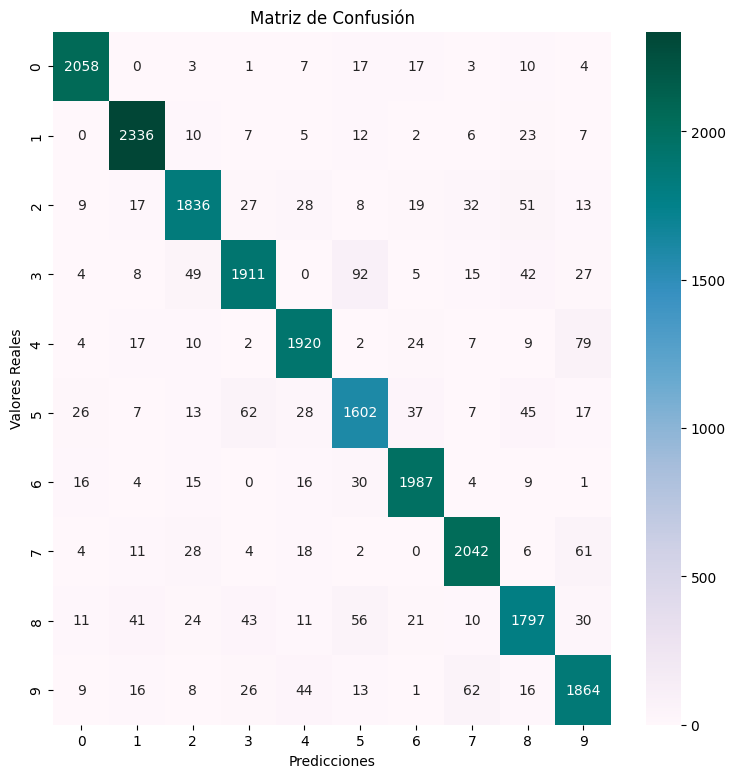

In [29]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_LR, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

Por último, se selecciona una muestra aleatoria de 8 dígitos entre el conjunto de imágenes de prueba y se muestran los valores de predicción del modelo y el valor real correspondiente a la imagen.

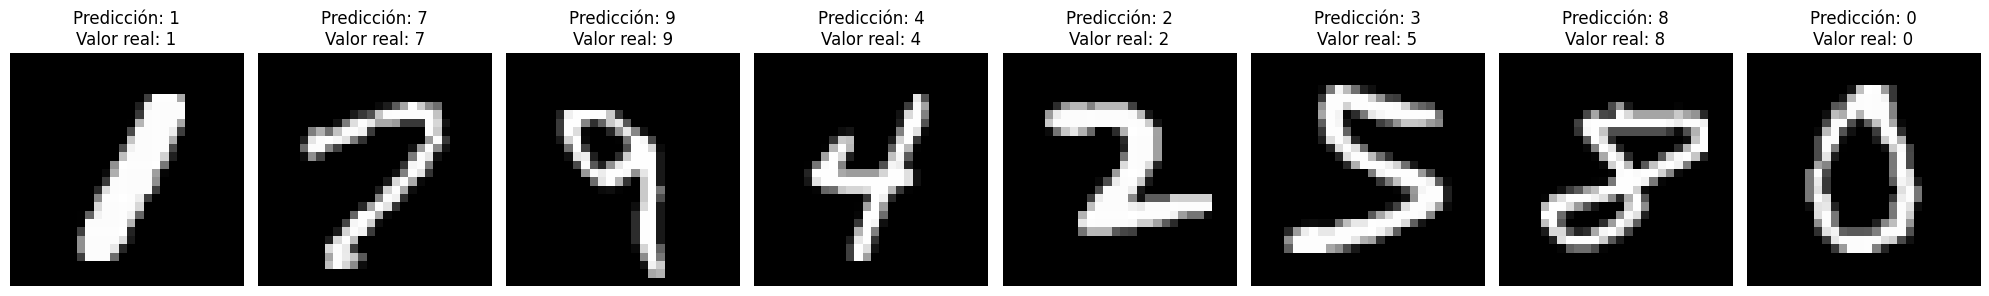

In [31]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_LR[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## K-Vecinos

El segundo modelo que vamos a utilizar corresponda a [K-Nearest Neighbors (KNN)](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) también conocido como K-Vecinos o K-Vecinos más cercanos.

---

### Seccion 1

Explicacion e import de las librerias necesarias para el modelo

In [17]:
from sklearn.neighbors import KNeighborsClassifier

### Seccion 2, seleccion de hiperparametros, scores y entrenamiento

Explicacion de los hiperparametros de KNN y el como se obtienen sus valores optimos
* K:
* Pesos:
* Distancia:

In [ ]:
#Se definen los parámetros a estimar
param_grid_KNN = {
    'n_neighbors': range(2, 5),
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
    }

In [18]:
#Este fragmento de código contiene los mejores valores
#para los parámetros, esto con la finalidad de
#no tener que calcularlos en cada inicio del notebook
param_grid_KNN = {
    'n_neighbors': [3],
    'weights': ['distance'],
    'metric': ['euclidean']
    }

In [19]:
#Se usa GridSearchCV para los calculos de los hiperparámetros y de los scores
grid_search = GridSearchCV(KNeighborsClassifier(), param_grid_KNN, cv = 5, scoring = scores, refit='f1_weighted')

#Shhhh... Machine is Learning (again)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['euclidean'], 'n_neighbors': [3],
                         'weights': ['distance']},
             refit='f1_weighted', scoring=['accuracy', 'f1_weighted'])

Después de haber realizado las pruebas correspondientes, se obtuvieron los siguientes valores para los hiperparámetros:

* K = 3
* weights = 'distance'
* metric = 'euclidean'

In [20]:
print(f"Mejores hiperparámetros encontrados:\n")
print(f"Best K: {grid_search.best_params_['n_neighbors']}")
print(f"Best weights: {grid_search.best_params_['weights']}")
print(f"Best metric: {grid_search.best_params_['metric']}")
print(f"F1 Score (weighted): {grid_search.cv_results_['mean_test_f1_weighted'].mean() * 100:.2f}%")
print(f"Accuracy: {grid_search.cv_results_['mean_test_accuracy'].mean() * 100:.2f}%")

Mejores hiperparámetros encontrados:

Best K: 3
Best weights: distance
Best metric: euclidean
F1 Score (weighted): 96.99%
Accuracy: 96.99%


### Sección 3, pruebas con el modelo

In [21]:
modelKNN = grid_search.best_estimator_

Resultados obtenidos:

In [22]:
#Primeras predicciones del modelo:
y_pred_KNN = modelKNN.predict(X_test)

#Se calcula la precisión obtenida
acc_pred_KNN = modelKNN.score(X_test, y_test)

#Se calcula la matriz de confusión asociada
conf_matrix_KNN = confusion_matrix(y_test, y_pred_KNN)

print(f"Predicciones: {y_pred_KNN}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_KNN * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 97.27%


Visualizaciones

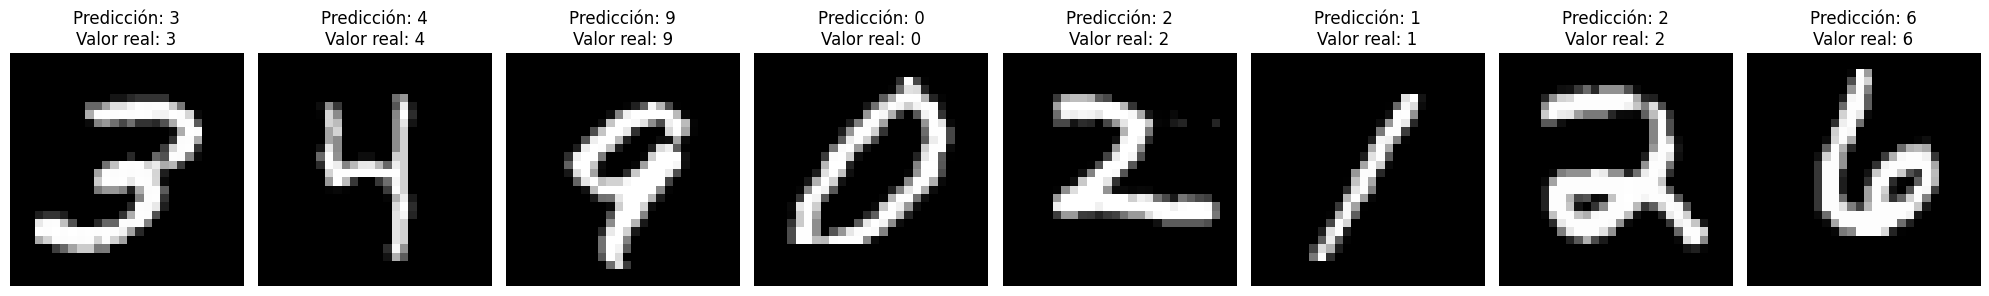

In [23]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_KNN[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Matriz de confusion:

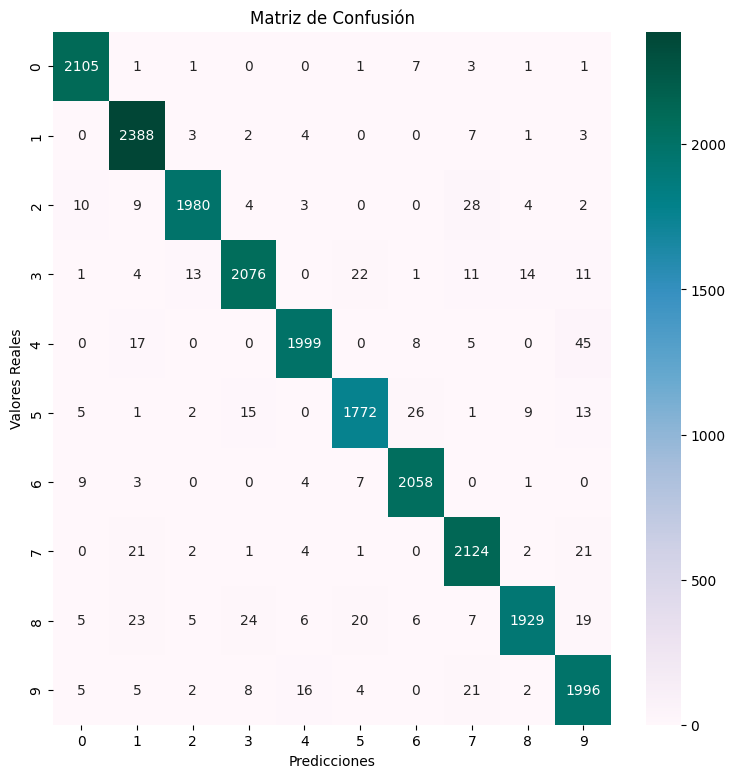

In [24]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_KNN, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

## SVM

Breve explicación de SVM

---

### Seccion 1, import del modelo

In [25]:
from sklearn.svm import SVC

### Sección 2, cálculo de hiperparámetros, scores y entrenamiento

In [34]:
param_grid_SVM = {
    'C': [0.01, 0.1, 1, 10, 100],
    'gamma': [0.01, 0.1, 1]
}

In [37]:
param_grid_SVM = {
    'gamma': [0.01, 0.1, 1]
}

In [ ]:
grid_search_SVM = GridSearchCV(SVC(kernel = 'rbf', C=10), param_grid_SVM, cv = 5, scoring = scores, refit='f1_weighted')

#Be quiet... Machine's Learnig over here
grid_search_SVM.fit(X_train, y_train)

In [28]:
print(f"Resultados obtenidos:\n")
print(f"Hiperparámetros encontrados: {grid_search_SVM.best_params_}")
print(f"F1 Score (weighted): {grid_search_SVM.cv_results_['mean_test_f1_weighted'].mean() * 100:.2f}%")
print(f"Accuracy: {grid_search_SVM.cv_results_['mean_test_accuracy'].mean() * 100:.2f}%")

Resultados obtenidos:

Hiperparámetros encontrados: {'C': 10}
F1 Score (weighted): 98.16%
Accuracy: 98.16%


### Sección 3, pruebas del modelo

In [29]:
modelSVM = grid_search_SVM.best_estimator_

In [30]:
y_pred_SVM = modelSVM.predict(X_test)

acc_pred_SVM = accuracy_score(y_test, y_pred_SVM)

conf_matrix_SVM = confusion_matrix(y_test, y_pred_SVM)

In [31]:
print(f"Predicciones: {y_pred_SVM}\nValores Reales: {y_test}\n")
print(f"Accuracy: {acc_pred_SVM * 100:.2f}%")

Predicciones: [0 9 1 ... 7 4 7]
Valores Reales: [0 9 1 ... 7 4 7]

Accuracy: 98.24%


### Visualizaciones

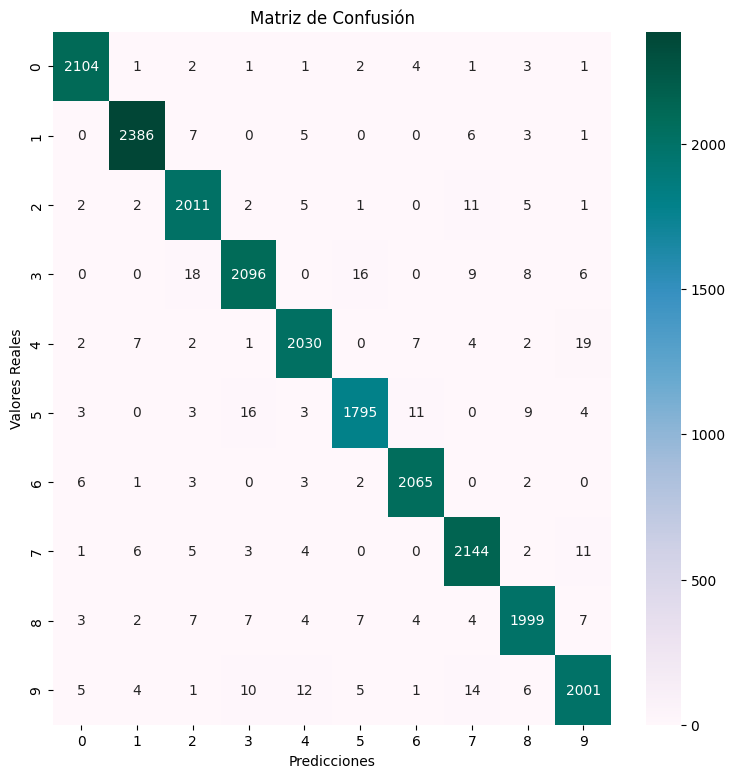

In [32]:
plt.figure(figsize = (9, 9))

sns.heatmap(
    conf_matrix_SVM, annot = True,
    fmt = 'd',
    cmap = 'PuBuGn',
    xticklabels = range(10),
    yticklabels = range(10)
    )

plt.title('Matriz de Confusión')
plt.xlabel('Predicciones')
plt.ylabel('Valores Reales')
plt.show()

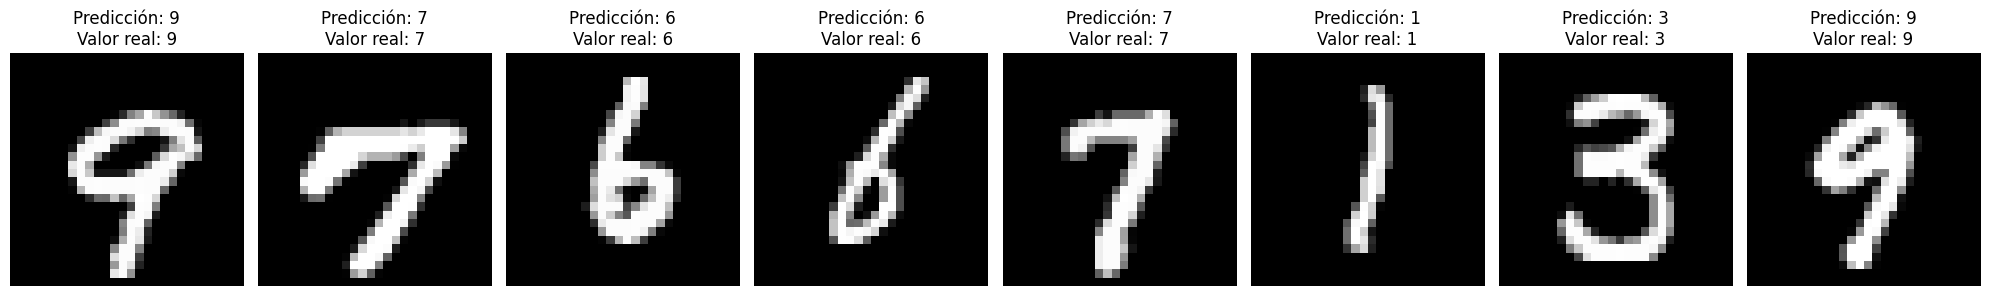

In [33]:
samples = 8
samples_index = np.random.choice(len(X_test), samples, replace = False)

plt.figure(figsize=(20, 10))

for i, index in enumerate(samples_index):
    plt.subplot(1, samples, i + 1)
    plt.imshow(X_test[index].reshape(28, 28), cmap = 'gray')
    plt.title(f"Predicción: {y_pred_SVM[index]}\nValor real: {y_test[index]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

## Conclusiones


In [ ]:
filename = 'final_model.joblib'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')